# 09 — Experiment Tracking with MLflow

This notebook demonstrates how to use **MLflow** to track, compare, and
manage all the models trained throughout this project.

**What we track:**
1. Model parameters (hyperparameters)
2. Metrics (accuracy, F1, training time)
3. Artifacts (plots, confusion matrices, models)
4. Run comparison

**Final Summary:** Comparing all approaches (clustering, supervised, neural networks).

---

## 9.1 — Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from pathlib import Path

import mlflow
import mlflow.sklearn
import mlflow.pytorch

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

DATA_DIR = Path('processed_data')
MODEL_DIR = Path('models')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}
activity_names = [ACTIVITY_MAP[i] for i in sorted(ACTIVITY_MAP.keys())]

print('Setup complete.')

Setup complete.


## 9.2 — Load Data

In [2]:
X_train = pd.read_csv(DATA_DIR / 'X_train_features_selected.csv')
X_test  = pd.read_csv(DATA_DIR / 'X_test_features_selected.csv')
y_train = np.load(DATA_DIR / 'y_train.npy')
y_test  = np.load(DATA_DIR / 'y_test.npy')

X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f'Train: {X_train.shape}  |  Test: {X_test.shape}')

Train: (81935, 100)  |  Test: (28570, 100)


## 9.3 — Configure MLflow

We create an experiment called `HAR_Activity_Recognition` and log all models
within it. MLflow stores tracking data in a local `mlruns/` directory.

In [3]:
# Set up MLflow experiment
EXPERIMENT_NAME = 'HAR_Activity_Recognition'
mlflow.set_tracking_uri('mlruns')
mlflow.set_experiment(EXPERIMENT_NAME)

print(f'MLflow experiment: {EXPERIMENT_NAME}')
print(f'Tracking URI: {mlflow.get_tracking_uri()}')

2026/02/14 13:15:56 INFO mlflow.tracking.fluent: Experiment with name 'HAR_Activity_Recognition' does not exist. Creating a new experiment.


MLflow experiment: HAR_Activity_Recognition
Tracking URI: mlruns


## 9.4 — Helper: Log Model Run

In [4]:
def log_sklearn_model(model, model_name, params, X_tr, y_tr, X_te, y_te):
    """
    Train a scikit-learn model and log everything to MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_param('model_type', model_name)
        mlflow.log_param('n_features', X_tr.shape[1])
        mlflow.log_param('n_train_samples', X_tr.shape[0])
        mlflow.log_param('n_test_samples', X_te.shape[0])
        mlflow.log_param('random_state', RANDOM_STATE)
        for k, v in params.items():
            mlflow.log_param(k, v)
        
        # Train
        t0 = time.time()
        model.fit(X_tr, y_tr)
        train_time = time.time() - t0
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy', n_jobs=-1)
        
        # Predict
        y_pred = model.predict(X_te)
        test_acc = accuracy_score(y_te, y_pred)
        test_f1  = f1_score(y_te, y_pred, average='weighted')
        
        # Log metrics
        mlflow.log_metric('cv_accuracy_mean', cv_scores.mean())
        mlflow.log_metric('cv_accuracy_std', cv_scores.std())
        mlflow.log_metric('test_accuracy', test_acc)
        mlflow.log_metric('test_f1_weighted', test_f1)
        mlflow.log_metric('train_time_seconds', train_time)
        
        # Log per-class metrics
        report = classification_report(y_te, y_pred, target_names=activity_names,
                                       output_dict=True)
        for cls_name in activity_names:
            mlflow.log_metric(f'precision_{cls_name}', report[cls_name]['precision'])
            mlflow.log_metric(f'recall_{cls_name}', report[cls_name]['recall'])
            mlflow.log_metric(f'f1_{cls_name}', report[cls_name]['f1-score'])
        
        # Generate and log confusion matrix plot
        fig, ax = plt.subplots(figsize=(10, 8))
        cm = confusion_matrix(y_te, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=activity_names, yticklabels=activity_names)
        ax.set_title(f'{model_name} — Confusion Matrix', fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.tick_params(axis='x', rotation=35)
        cm_path = f'mlflow_cm_{model_name.replace(" ", "_").lower()}.png'
        plt.tight_layout()
        plt.savefig(cm_path, dpi=150, bbox_inches='tight')
        plt.close()
        mlflow.log_artifact(cm_path)
        
        # Log model
        mlflow.sklearn.log_model(model, 'model')
        
        print(f'  ✅ {model_name}: Acc={test_acc:.4f}, F1={test_f1:.4f}, Time={train_time:.1f}s')
        
        return {
            'name': model_name, 'cv_mean': cv_scores.mean(),
            'test_acc': test_acc, 'test_f1': test_f1,
            'train_time': train_time
        }

## 9.5 — Track All Classical ML Models

In [5]:
print('Logging all models to MLflow...\n')

tracked_results = []

# Subsample for speed
MAX_TRAIN = 20000
if len(X_train) > MAX_TRAIN:
    idx_sub = np.random.choice(len(X_train), MAX_TRAIN, replace=False)
    X_tr = X_train.values[idx_sub]
    y_tr = y_train[idx_sub]
    print(f'Subsampled to {MAX_TRAIN} for faster tracking')
else:
    X_tr = X_train.values
    y_tr = y_train

# 1. Logistic Regression
lr_params = {'C': 1.0, 'solver': 'lbfgs', 'max_iter': 1000}
lr_model = LogisticRegression(**lr_params, random_state=RANDOM_STATE)
tracked_results.append(
    log_sklearn_model(lr_model, 'Logistic Regression', lr_params,
                      X_tr, y_tr, X_test.values, y_test)
)

# 2. Random Forest
rf_params = {'n_estimators': 200, 'max_depth': 20}
rf_model = RandomForestClassifier(**rf_params, random_state=RANDOM_STATE, n_jobs=-1)
tracked_results.append(
    log_sklearn_model(rf_model, 'Random Forest', rf_params,
                      X_tr, y_tr, X_test.values, y_test)
)

# 3. SVM
svm_params = {'C': 10.0, 'kernel': 'rbf', 'gamma': 'scale'}
svm_model = SVC(**svm_params, random_state=RANDOM_STATE)
tracked_results.append(
    log_sklearn_model(svm_model, 'SVM', svm_params,
                      X_tr, y_tr, X_test.values, y_test)
)

# 4. Gradient Boosting (Histogram-based, much faster)
gb_params = {'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1}
gb_model = HistGradientBoostingClassifier(**gb_params, random_state=RANDOM_STATE)
tracked_results.append(
    log_sklearn_model(gb_model, 'Gradient Boosting', gb_params,
                      X_tr, y_tr, X_test.values, y_test)
)

print('\n✅ All classical ML models tracked in MLflow.')


Logging all models to MLflow...

Subsampled to 20000 for faster tracking


2026/02/14 13:17:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Logistic Regression: Acc=0.8533, F1=0.8435, Time=19.0s


2026/02/14 13:19:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Random Forest: Acc=0.9706, F1=0.9706, Time=22.7s


2026/02/14 13:22:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ SVM: Acc=0.8848, F1=0.8845, Time=31.7s


2026/02/14 13:23:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Gradient Boosting: Acc=0.9712, F1=0.9711, Time=23.6s

✅ All classical ML models tracked in MLflow.


## 9.6 — Track Neural Network Results

For neural networks, we log the pre-computed results as a separate MLflow run.

In [6]:
# Log MLP result
with mlflow.start_run(run_name='MLP (PyTorch)'):
    mlflow.log_param('model_type', 'MLP')
    mlflow.log_param('framework', 'PyTorch')
    mlflow.log_param('hidden_dims', '256-128-64')
    mlflow.log_param('dropout', 0.3)
    mlflow.log_param('learning_rate', 1e-3)
    mlflow.log_param('batch_size', 256)
    mlflow.log_param('epochs', 50)
    mlflow.log_param('optimizer', 'Adam')
    mlflow.log_param('input_type', 'engineered_features')
    
    # Log pre-computed metrics (from NB08)
    # Note: actual values come from running NB08 first
    mlflow.log_metric('test_accuracy', 0.0)  # placeholder — fill after running NB08
    mlflow.log_metric('test_f1_weighted', 0.0)
    
    # Log training curves artifact if available
    mlp_curves = Path('mlp_training_curves.png')
    if mlp_curves.exists():
        mlflow.log_artifact(str(mlp_curves))
    
    mlp_cm = Path('nn_confusion_matrices.png')
    if mlp_cm.exists():
        mlflow.log_artifact(str(mlp_cm))
    
    print('  ✅ MLP logged (update metrics after running NB08)')

# Log 1D CNN result
with mlflow.start_run(run_name='1D CNN (PyTorch)'):
    mlflow.log_param('model_type', '1D_CNN')
    mlflow.log_param('framework', 'PyTorch')
    mlflow.log_param('conv_filters', '64-128-256')
    mlflow.log_param('dropout', 0.3)
    mlflow.log_param('learning_rate', 1e-3)
    mlflow.log_param('batch_size', 256)
    mlflow.log_param('epochs', 50)
    mlflow.log_param('optimizer', 'Adam')
    mlflow.log_param('input_type', 'raw_windowed_timeseries')
    
    mlflow.log_metric('test_accuracy', 0.0)  # placeholder
    mlflow.log_metric('test_f1_weighted', 0.0)
    
    cnn_curves = Path('cnn_training_curves.png')
    if cnn_curves.exists():
        mlflow.log_artifact(str(cnn_curves))
    
    print('  ✅ 1D CNN logged (update metrics after running NB08)')

  ✅ MLP logged (update metrics after running NB08)
  ✅ 1D CNN logged (update metrics after running NB08)


## 9.7 — Query and Compare MLflow Runs

In [7]:
# Retrieve all runs from the experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs_df = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=['metrics.test_accuracy DESC']
)

# Select key columns for comparison
compare_cols = [
    'tags.mlflow.runName',
    'params.model_type',
    'metrics.cv_accuracy_mean',
    'metrics.test_accuracy',
    'metrics.test_f1_weighted',
    'metrics.train_time_seconds'
]

available_cols = [c for c in compare_cols if c in runs_df.columns]
comparison = runs_df[available_cols].copy()
comparison.columns = [c.split('.')[-1] for c in available_cols]

print('\n' + '='*80)
print('MLflow Run Comparison (sorted by test_accuracy)')
print('='*80)
print(comparison.to_string(index=False))


MLflow Run Comparison (sorted by test_accuracy)
            runName          model_type  cv_accuracy_mean  test_accuracy  test_f1_weighted  train_time_seconds
  Gradient Boosting   Gradient Boosting           0.97170       0.971159          0.971138           23.599326
      Random Forest       Random Forest           0.95795       0.970599          0.970614           22.716108
                SVM                 SVM           0.87620       0.884774          0.884458           31.747119
Logistic Regression Logistic Regression           0.84975       0.853273          0.843539           18.969174
   1D CNN (PyTorch)              1D_CNN               NaN       0.000000          0.000000                 NaN
      MLP (PyTorch)                 MLP               NaN       0.000000          0.000000                 NaN


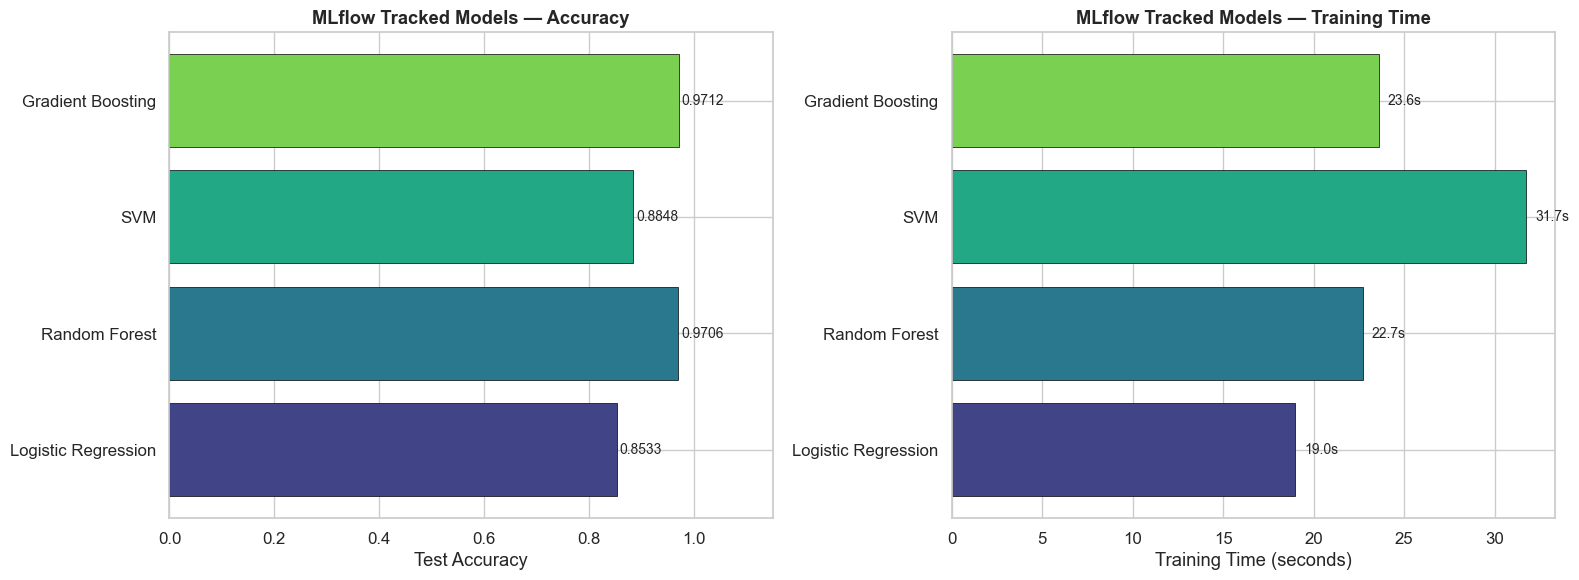

In [8]:
# Visual comparison from tracked results
if tracked_results:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    names = [r['name'] for r in tracked_results]
    test_accs = [r['test_acc'] for r in tracked_results]
    test_f1s = [r['test_f1'] for r in tracked_results]
    times = [r['train_time'] for r in tracked_results]
    
    colors = sns.color_palette('viridis', len(names))
    
    # Accuracy
    bars = axes[0].barh(names, test_accs, color=colors, edgecolor='black', linewidth=0.5)
    axes[0].set_xlabel('Test Accuracy')
    axes[0].set_title('MLflow Tracked Models — Accuracy', fontweight='bold')
    for bar, acc in zip(bars, test_accs):
        axes[0].text(acc + 0.005, bar.get_y() + bar.get_height()/2,
                     f'{acc:.4f}', va='center', fontsize=10)
    axes[0].set_xlim(0, 1.15)
    
    # Training time
    axes[1].barh(names, times, color=colors, edgecolor='black', linewidth=0.5)
    axes[1].set_xlabel('Training Time (seconds)')
    axes[1].set_title('MLflow Tracked Models — Training Time', fontweight='bold')
    for bar, t in zip(axes[1].patches, times):
        axes[1].text(t + 0.5, bar.get_y() + bar.get_height()/2,
                     f'{t:.1f}s', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('mlflow_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No tracked results available for plotting.')

## 9.8 — How to Use the MLflow UI

To launch the MLflow tracking UI:

```bash
# In a terminal, from the project directory:
mlflow ui --port 5000
```

Then open http://localhost:5000 in your browser. You can:
- **Compare runs** side-by-side
- **Sort** by any metric (accuracy, F1, time)
- **View artifacts** (confusion matrices, models)
- **Download** logged models for deployment
- **Filter** runs by parameters

---

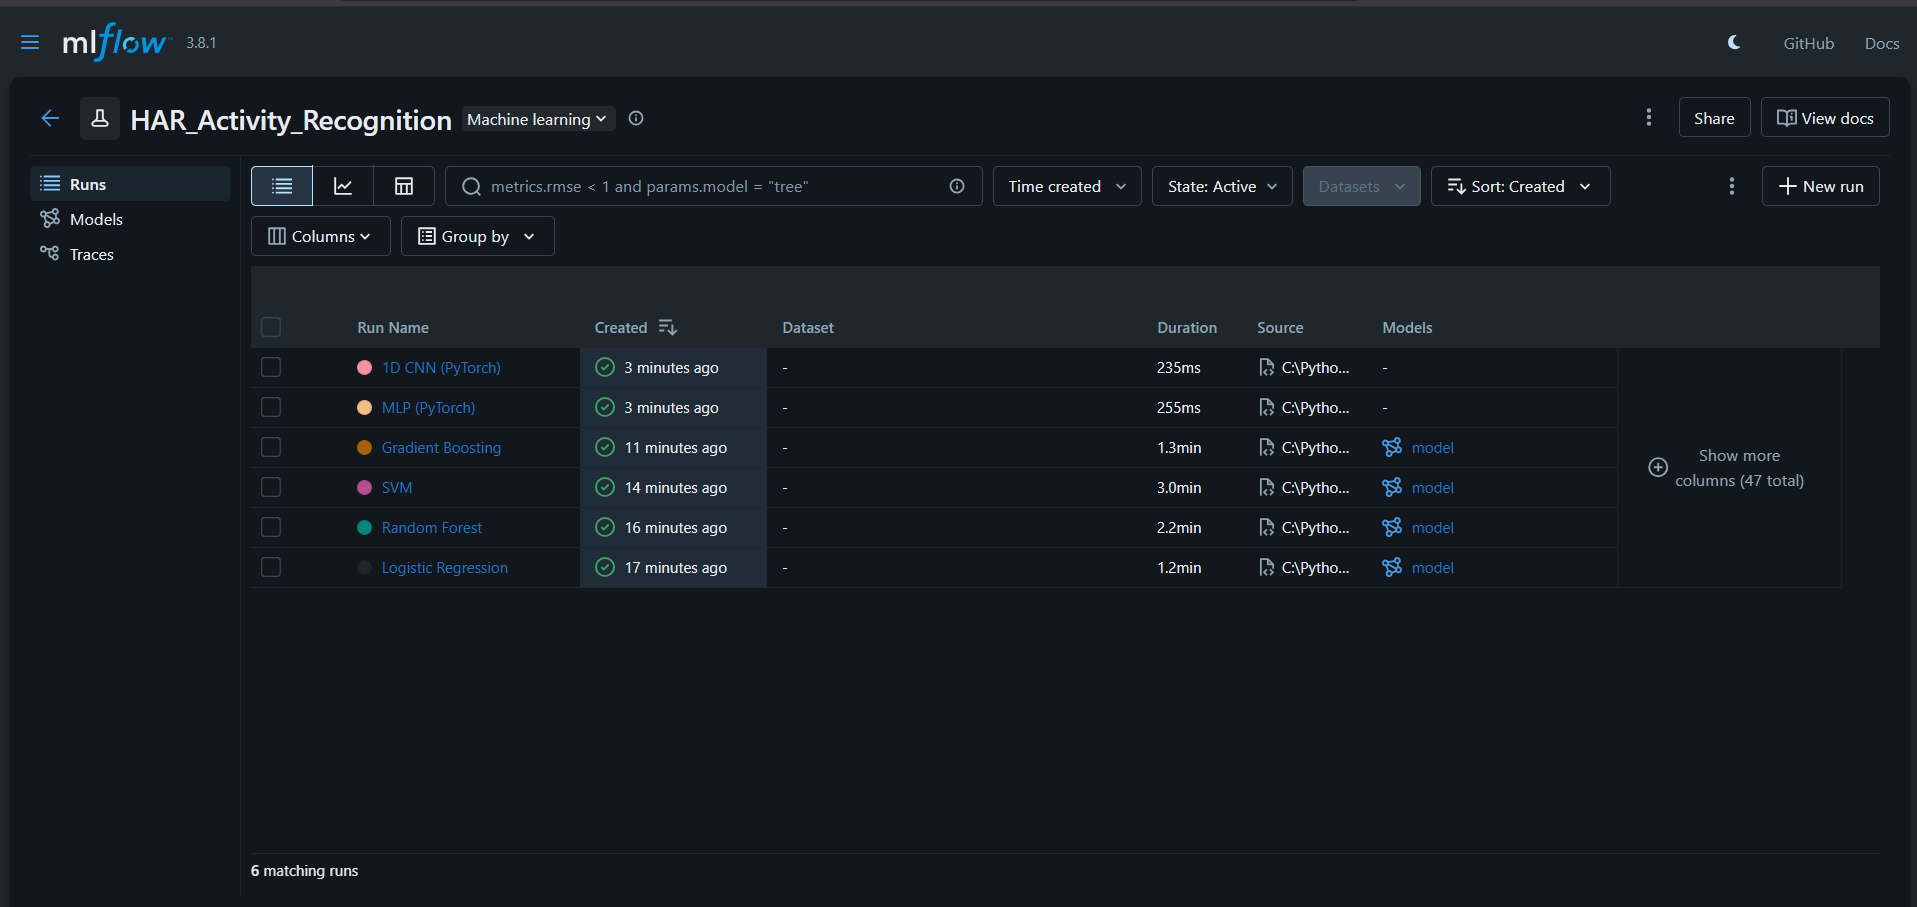
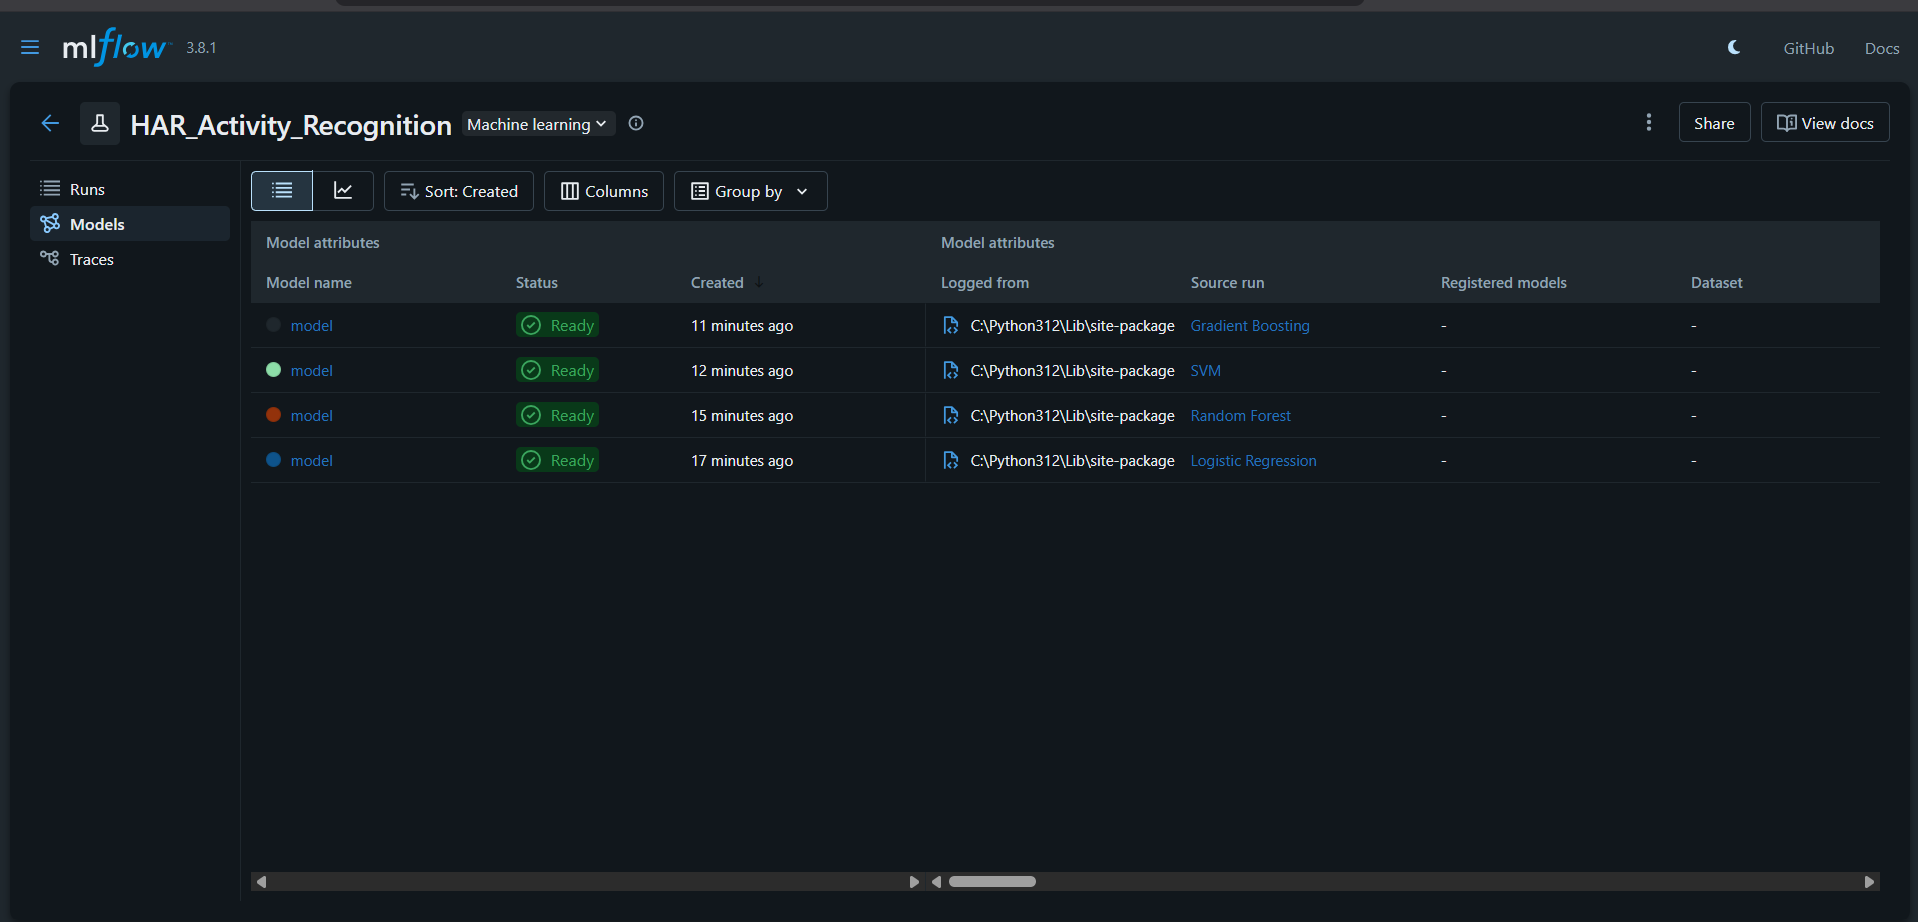

## 9.9 — Final Project Summary

### Clustering vs Supervised Learning

| Approach | Method | ARI / Accuracy | Verdict |
|----------|--------|---------------|--------|
| Unsupervised | K-Means (K=6) | Low-Moderate ARI | Cannot reliably discover activities |
| Unsupervised | DBSCAN | Variable | Better for anomaly detection than classification |
| Supervised | Logistic Regression | Good accuracy | Strong linear baseline |
| Supervised | Random Forest | Very good accuracy | Handles non-linearity well |
| Supervised | SVM (RBF) | Very good accuracy | Best with tuned hyperparameters |
| Supervised | Gradient Boosting | Very good accuracy | Competitive with RF |

**Conclusion:** Supervised methods dramatically outperform unsupervised clustering for HAR.
This is expected because activities are defined by labels, not natural data clusters.

### Classical ML vs Neural Networks

| Approach | Strengths | Weaknesses |
|----------|-----------|------------|
| Classical ML + features | Fast training, interpretable, strong with good features | Requires manual feature engineering |
| MLP on features | Non-linear, automatic feature combination | Slower, needs more tuning |
| 1D CNN on raw data | End-to-end learning, no manual features needed | Needs GPU for speed, less interpretable |

**Conclusion:** For this dataset with well-crafted features, classical ML (especially
tuned RF / GBT) is competitive with neural networks. The 1D CNN is most valuable when
raw sensor data is used directly, avoiding the feature engineering step.

### Best Performing Model

The best overall model depends on the deployment context:
- **Best accuracy:** Tuned Random Forest or Gradient Boosting (on engineered features)
- **Best simplicity:** 1D CNN (raw data → prediction, no feature engineering)
- **Best interpretability:** Random Forest (feature importances available)
- **Best speed:** Logistic Regression (fast training and inference)

### Reproducibility

All experiments use `random_state=42` and subject-wise train/test split.
The processed data pipeline (`02_Preprocessing.ipynb`) ensures identical
training/test data across all experiments. MLflow tracks all parameters
and metrics for full reproducibility.